# Adjacent layer backpropagation

Here I'm going to:

- take my multitask model from before
- extract adjacent layer gradients using the mapping method with the network scaffold I suppose with _normalised_ gradients from the following layer (so as to keep the edge-weights layer-wise, not output-wise - the idea is to create some kind of flow)
- extract the intralayer gradients by dotting between gradients for each of the following layer's components. This is a bit difficult to explain but hopefully in code it'll make more sense.
- create the edge weights accordingly

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1322468781  # this one is very interesting
set_all_seeds(seed)
print(seed)

1863375946


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


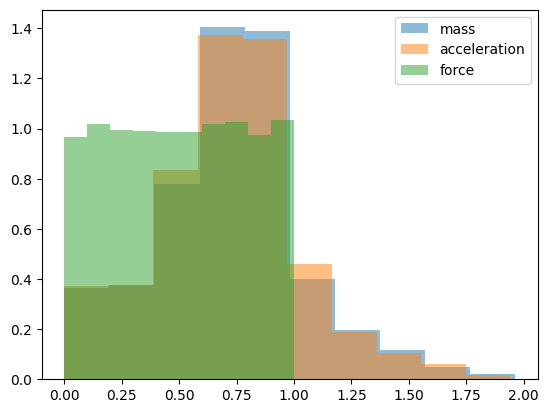

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

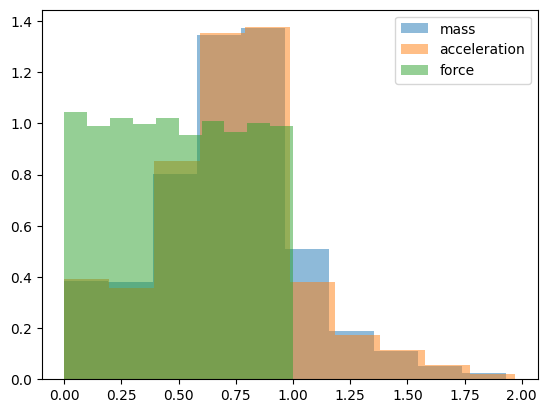

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

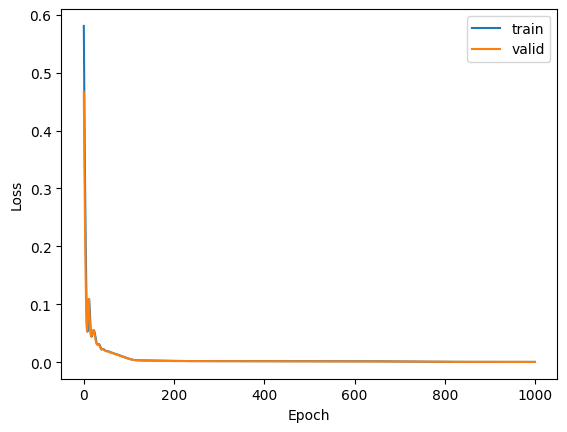

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0005)

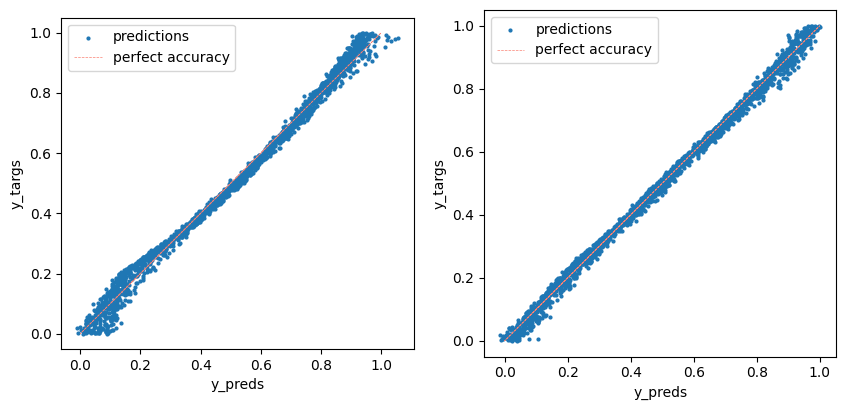

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [33]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid
task_ios = capture_intermediate_outputs(model, task_inputs)
task_ios["input"] = task_inputs

In [24]:
valid_ios["layers.0.act"].shape, valid_ios["layers.1.act"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [25]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [36]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet()
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [46]:
layer_keys[::-1][1:]

['layers.1.act', 'layers.0.act', 'input']

In [70]:
out.shape

torch.Size([2000, 16])

In [94]:
grads = {}
layer_keys = ["input", "layers.0.act", "layers.1.act", "output"]
reversed_layer_keys = layer_keys[::-1]
reverse_indices = list(range(len(layer_keys) - 1))[::-1]
out_grad_comps = None
for lidx, lk_input, lk_output in zip(
    reverse_indices,
    reversed_layer_keys[1:],
    reversed_layer_keys[:-1],
):  # iterate over pairs of layers at a time
    print(lidx, lk_input, lk_output)
    linputs = valid_ios[lk_input].clone().requires_grad_(True)
    out = scaffold_model(lidx, linputs)
    if (
        out_grad_comps is not None
    ):  # not at the final layer so need to convert to components as opposed to outputs
        out = torch.einsum("ij,kj->ik", out, out_grad_comps)

    grads[lk_input] = []
    for out_comp in out.transpose(1, 0):
        loss = out_comp.mean()
        loss.backward(retain_graph=True)
        input_grads = linputs.grad.clone().detach()
        uq_input_grads = input_grads.unique(dim=0)
        input_norms = torch.norm(uq_input_grads, dim=1)
        sort_idx = torch.argsort(input_norms, descending=True)
        uq_input_grads = uq_input_grads[sort_idx]
        grads[lk_input].append(uq_input_grads)
        linputs.grad.zero_()
        out_grad_comps = uq_input_grads.clone().requires_grad_(False)

    if lk_input == "layers.1.act":
        break


# for i, task in enumerate(tasks):
#     linputs = valid_ios["layers.0.act"].clone().requires_grad_(True)
#     out = scaffold_model(1, linputs)
#     loss = out[:, i].mean()
#     loss.backward()
#     grads[task] = {}
#     grads[task]["gradients"] = linputs.grad.clone().detach()

# for task, _ in grads.items():
#     grads[task]["pcs"], grads[task]["vars"] = get_pcs(grads[task]["gradients"])
#     uq_grads = grads[task]["gradients"].unique(dim=0)
#     uq_grads_norm = uq_grads.norm(dim=1)
#     grads[task]["unique"] = {}
#     grads[task]["unique"]["comps"] = uq_grads / uq_grads_norm[:, None]
#     grads[task]["unique"]["norms"] = uq_grads_norm

2 layers.1.act output


In [95]:
out_grad_comps.shape

torch.Size([1, 16])

In [92]:
out.shape

torch.Size([2000, 1])

In [90]:
[len(t) for t in grads.values()]

[2, 1, 8]

In [82]:
uq_input_grads

tensor([[ 1.9234e-03,  8.7522e-04, -4.3786e-04, -1.1296e-04],
        [ 1.6065e-03,  8.7282e-04, -3.4096e-04,  9.2470e-04],
        [ 1.2855e-03,  1.2082e-03, -3.2955e-04,  9.3283e-04],
        [ 1.5764e-03,  8.6429e-04, -5.3897e-04,  7.2888e-04],
        [ 1.4122e-03,  7.0444e-04, -2.4291e-04,  1.2029e-03],
        [ 1.2554e-03,  1.1997e-03, -5.2755e-04,  7.3701e-04],
        [ 1.7432e-03,  8.4343e-04, -2.2854e-04,  9.7527e-05],
        [ 1.0912e-03,  1.0399e-03, -2.3150e-04,  1.2111e-03],
        [ 1.6060e-03,  8.7120e-04, -5.8289e-06,  5.3426e-04],
        [ 1.3820e-03,  6.9590e-04, -4.4092e-04,  1.0071e-03],
        [ 1.0610e-03,  1.0313e-03, -4.2950e-04,  1.0152e-03],
        [ 1.2850e-03,  1.2066e-03,  5.5850e-06,  5.4239e-04],
        [ 1.5759e-03,  8.6266e-04, -2.0383e-04,  3.3845e-04],
        [ 1.5073e-03,  7.5513e-04,  1.8328e-04,  5.8443e-04],
        [ 1.2549e-03,  1.1981e-03, -1.9242e-04,  3.4658e-04],
        [ 1.1863e-03,  1.0906e-03,  1.9470e-04,  5.9256e-04],
        

In [38]:
out

tensor([[0.6908, 0.0889],
        [0.1177, 0.8205],
        [0.6280, 0.1391],
        ...,
        [0.0836, 0.4162],
        [0.0484, 0.2168],
        [0.0922, 0.4455]], grad_fn=<AddmmBackward0>)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, task in zip(axes, ("A", "B")):
    ax.bar(range(1, 17), grads[task]["vars"])
    ax.set_title(f"Task {task}")
    ax.set_xlabel("PC")
    ax.set_ylabel("Variance")

fig.suptitle("Task-wise principal components of activation gradients")
fig.set_tight_layout("tight")

The mean is crude but it could be informative:

In [ ]:
meanA = grads["A"]["gradients"].mean(0)
meanB = grads["B"]["gradients"].mean(0)
meanA = meanA / meanA.norm()
meanB = meanB / meanB.norm()

torch.dot(meanA, meanB)

In [ ]:
sims = torch.einsum(
    "ij,kj->ik", grads["A"]["unique"]["comps"], grads["B"]["unique"]["comps"]
).numpy()

In [ ]:
def plot_similarity(sims, title="Dot-product Similarity", x_label=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(title, fontsize=16)

    # I'm pretty sure this is the right way round from ij,ik->jk?
    ax.set_xlabel("Task B PCA", fontsize=14)
    ax.set_ylabel("Task A PCA", fontsize=14)

In [ ]:
plot_similarity(sims, title="Dot-product Similarity")

In [ ]:
sliceA = slice(0, 10000)
sliceB = slice(10000, None)

### Task A PCs

I'm first focusing on the gradient PCs extracted from backprop from the task A output and how much variance they explain in both tasks.

In [ ]:
task = "A"

Calculating how much variance is explained by these gradient PCs across both task datasets:

In [ ]:
sort_idxs = grads[task]["unique"]["norms"].argsort(descending=True)
norms = grads[task]["unique"]["norms"][sort_idxs]
grad_acts = torch.einsum("ij,kj->ki", grads[task]["unique"]["comps"], task_acts["0"])[
    :, sort_idxs
]
varA = grad_acts[sliceA].var(0)
varB = grad_acts[sliceB].var(0)
varA.shape, varB.shape

In [ ]:
def plot_pca_variances(varA, varB, grad_pc_variance, err_varA=None, err_varB=None):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot the variances for Task A and Task B
    ax1.bar(
        range(len(varA)),
        varA,
        yerr=err_varA,
        width=0.4,
        align="center",
        label="Task A activations",
        alpha=0.5,
    )
    ax1.bar(
        range(len(varB)),
        varB,
        yerr=err_varB,
        width=0.4,
        align="center",
        label="Task B activations",
        alpha=0.5,
    )
    ax1.set_xlabel("Unique Gradient Component")
    ax1.set_ylabel("Variance")
    ax1.legend(loc="upper left")

    # Create a second y-axis for PC importance
    ax2 = ax1.twinx()
    ax2.scatter(
        range(len(grad_pc_variance)),
        grad_pc_variance,
        label="Gradient Component Norm",
        color="r",
        marker="o",
    )
    ax2.set_ylim(0)
    ax2.set_ylabel("Norm")
    ax2.legend(loc="upper right")

    ax1.set_title(
        "Task-wise variance explained in activations by each unique gradient component"
    )

In [ ]:
plot_pca_variances(varA, varB, norms)

### Task B PCs

In [ ]:
task = "B"

In [ ]:
sort_idxs = grads[task]["unique"]["norms"].argsort(descending=True)
norms = grads[task]["unique"]["norms"][sort_idxs]
grad_acts = torch.einsum("ij,kj->ki", grads[task]["unique"]["comps"], task_acts["0"])[
    :, sort_idxs
]
varA = grad_acts[sliceA].var(0)
varB = grad_acts[sliceB].var(0)
varA.shape, varB.shape

In [ ]:
plot_pca_variances(varA, varB, norms)

## Thoughts

Wow really went on a journey with this one.
- It took me a long time to notice (especially given that the dimensionality reduction techniques don't tend to deal with clusters of identical vectors as they should i.e. an infinitely dense cluster) but there is a **_discrete_ number of different gradients that are observed**. 
- That seemed pretty wild at first but I'm getting a better idea of maybe why this is to be expected. If we're working with simple linear layers and ReLUs, then I suppose this gives us an idea of the number of different orthants in which the data lies? This is a discrete number and behaviour (i.e. gradients) in each will be identical regardless of where you are in the orthant? Fits in with the piecewise picture too in this same way. Would be cool to prove/disprove this.
- This makes analysis much easier because "clustering" of components can be done by simply finding the unique gradients.
- It's nice to see that the resulting gradient components are very orthogonal across tasks.
- Plotting with the norm of the gradient component shows that the non-orthogonal components are always low importance as we'd hope.
- There are some really cool structural similarities between the norms of the gradients and the variances sometimes but maybe this would be expected from the fact that the data is input to both calculations.
- I suppose we could be seeing a bit of a return to the idea of modes given that some trained networks have far fewer unique gradients than others.
- **There are always the same number of unique gradients for task A as task B** (check this) - understand this. Perhaps it's because both go through the same layer afterwards?
- **There are often more unique components than there are dimensions - suggesting superposition?**
- The fact that we have this gradient splitting between different examples means the picture isn't as clear as simply picking out component and saying: this component is always used solely for e.g. task A because it could be that with combinations of input values it is used for task B. However, empirically, we can observe that the components are rarely very expressive at all across different tasks.
- How does the number of different components change with layer depth? Perhaps backpropagating to the input will break up the gradient into more distinct values. Intuitively, I'd imagine that the repulsion from solutions that involve destructive interference between tasks means that the number of gradient components is somewhat tied to the dimensionality of each layer.  

## Plan

- Devise mathematical notation to properly label all these quantities I've been plotting
- Apply same analysis across:
    - the other layers
    - more model repeats
- Think about how I can represent these as computational graphs to demonstrate orthogonal task computation
- Think about how I'm going to find components of interest in the wild (when I don't have the outputs to backpropagate from)
- Think about how I'd approach entity classification/embedding

## Thoughts about potential future in the wild structure discovery

- We surely only really care about the outputs as in: what algorithm is used to compute the outputs? Therefore, maybe **we could _always_ backpropagate from the outputs** (which is always going to be in a privileged basis)? For example, with an LM, the model can only "behave" in a certain way in so far as it outputs certain words in sequence. Therefore, this gives us a natural end-point from which to backpropagate. What I'm imagining is, with the help of a very varied dataset (ideally all the examples the model has ever seen?), building a computation graph for _every single_ possible output word. This would represent all of the ways that word can be generated. Provided our dataset has a very large number of contexts for the word being studied then we should stand a chance of finding all of the possible routes that would result in its generation. One could do a study on a token that has a very tightly defined context (e.g. punctuation) and we'd hope that its computational graph might be quite small/simple? I'm getting _very_ ahead of myself here but it's useful to write this stuff down.
- I also had the idea to create a very simple toy task where I deliberately **manufacture the problem to involve two (non-commutative) sub operatations** e.g. $y = x_1x_2 + x_3x_4$ which should consist of two multiplications and an addition, where the addition (should?) have to come after the multiplication. I can probably think of a neater example. This would have a single output but would be a great test of whether I can pull apart independent tasks _without_ the advantage of having a privileged basis to back propagate from.

## Thoughts about computation graph structure

- backprop 1 layer at a time starting from output layer
- at each layer use unique gradients as privileged basis for backprop to next layer
- edge weights represent the gradient norms inbound into a node
- to produce edge weights between between gradients calculated from different downstream nodes (if that makes any sense...) we need an analagous process to backprop:
    - could project the gradients from each node onto the gradients for the other node and then sum to find some total strength? Anything that affects the other node should be present in its gradients?
    - perturb your input with the other node's gradients and see how it affects the node in question. Then calculate $\frac{Δactivation}{Δinput}$ as one would do for gradients with backpropagation.
- if the current trend continues, I think it's likely we'd see two subgraphs emerging, one for each task
- we could, if we wanted to, label each node with a task activation (from our task-separated dataset), but I get the feeling that the graph with edge weights is closer to where we want to end up anyway (without the help of this artificial task dataset)
- this graph could apply across a single example or aggregated across a whole dataset. One could plot the graph for the whole dataset but it isn't as if that whole sub graph will be activated for every example.